In [1]:
import gzip as gz
import pandas as pd
import numpy as np

np.set_printoptions(suppress=True, precision=2)

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType

from pyspark.sql import functions as F

from operator import add

In [3]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

22/12/09 13:04:08 WARN Utils: Your hostname, Antons-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 172.20.10.2 instead (on interface en5)
22/12/09 13:04:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/09 13:04:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/12/09 13:04:11 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Data

Read known data fields with a schema

In [4]:
# loaded from auto-detect schema
schema = StructType([
    StructField('y', IntegerType(), True), 
    StructField('x1', IntegerType(), True), 
    StructField('x2', IntegerType(), True), 
    StructField('x3', IntegerType(), True), 
    StructField('x4', IntegerType(), True), 
    StructField('x5', IntegerType(), True), 
    StructField('x6', IntegerType(), True), 
    StructField('x7', IntegerType(), True), 
    StructField('x8', IntegerType(), True), 
    StructField('x9', IntegerType(), True), 
    StructField('x10', IntegerType(), True), 
    StructField('x11', IntegerType(), True), 
    StructField('x12', IntegerType(), True), 
    StructField('x13', IntegerType(), True), 
])

In [5]:
df_data = spark.read.options(delimiter="\t").csv("/Users/akusok/wrkdir/criteo/day_0_sample", schema=schema)
df_data = df_data.fillna(-1)

df_data.show(5)

+---+---+----+---+---+---+---+---+---+---+---+---+------+---+
|  y| x1|  x2| x3| x4| x5| x6| x7| x8| x9|x10|x11|   x12|x13|
+---+---+----+---+---+---+---+---+---+---+---+---+------+---+
|  0|  2| 190|  2| -1| -1|  0|  0|116|  0|  0| -1|388772|  2|
|  0|  5|1030|  0| 74|  3|  0|  0|  7| 39|  0|  3|   475| 33|
|  0| 77|2083|  8| -1| -1|  0|  0| 17|  6|  0| -1|  4973| 35|
|  0| 33| 403| 12| 36|  5|  0|  0| 22| 12|  0|  3|  5122| 12|
|  0| 37|   1| 15| -1| -1|  0|  0| 49|  0|  0| -1|    69| 22|
+---+---+----+---+---+---+---+---+---+---+---+---+------+---+
only showing top 5 rows



#### Let's scale one column

In [6]:
x12 = (
    df_data
    .limit(10000)
    .agg(
        F.mean("x12").alias("m"),
        F.stddev("x12").alias("s"),
    )
    .collect()
)

In [7]:
m = x12[0]['m']
s = x12[0]['s']

m, s

(23446.9994, 78512.2729654849)

In [8]:
df_data = df_data.withColumn("x12", (F.col("x12") - m) / s)

df_data.show(5)

+---+---+----+---+---+---+---+---+---+---+---+---+--------------------+---+
|  y| x1|  x2| x3| x4| x5| x6| x7| x8| x9|x10|x11|                 x12|x13|
+---+---+----+---+---+---+---+---+---+---+---+---+--------------------+---+
|  0|  2| 190|  2| -1| -1|  0|  0|116|  0|  0| -1|   4.653094182620366|  2|
|  0|  5|1030|  0| 74|  3|  0|  0|  7| 39|  0|  3|-0.29259119029834757| 33|
|  0| 77|2083|  8| -1| -1|  0|  0| 17|  6|  0| -1|-0.23530078422416112| 35|
|  0| 33| 403| 12| 36|  5|  0|  0| 22| 12|  0|  3|-0.23340299175972054| 12|
|  0| 37|   1| 15| -1| -1|  0|  0| 49|  0|  0| -1|-0.29776235634239373| 22|
+---+---+----+---+---+---+---+---+---+---+---+---+--------------------+---+
only showing top 5 rows



#### Scale outputs `y` for balanced representation

In [11]:
df_data.groupby("y").agg(F.count("*")).show()

+---+--------+
|  y|count(1)|
+---+--------+
|  1|   50446|
|  0| 1516697|
+---+--------+



In [12]:
1516697/50446

30.065753478967608

In [13]:
df_data = df_data.withColumn("y", F.col("y") * 30)

In [14]:
df_data.filter("y > 0").show(5)

+---+---+---+---+---+---+---+---+---+---+---+---+--------------------+---+
|  y| x1| x2| x3| x4| x5| x6| x7| x8| x9|x10|x11|                 x12|x13|
+---+---+---+---+---+---+---+---+---+---+---+---+--------------------+---+
| 30| -1| -1| -1|  0| -1| -1|  0| -1|  0| -1| -1| -0.2948328780415794| -1|
| 30|  1|466|  3|305|  7|  0|  0|  1|  5|  0|  7|-0.09336119211861783|  3|
| 30| -1| 68| -1|  2|  8| -1|  0| -1|  3| -1|  1|  0.2310466875411262| -1|
| 30| -1| -1|  1|  1| -1|  3|  0|  1|  1|  1| -1| -0.2939922451378675|  1|
| 30|  1| 36|  2| -1| -1|  0|  0|  0|  2|  0| -1| -0.2967561442303749|  2|
+---+---+---+---+---+---+---+---+---+---+---+---+--------------------+---+
only showing top 5 rows



## Setup

In [15]:
d = 13  # number of features in X
num_out = 1  # number of features in Y

l = 100  # number of hidden neurons

In [16]:
batch_N = 5000
batch_l = 65

In [17]:
W = np.random.randn(d, l-1)
W = np.hstack([ W, np.zeros((W.shape[0], 1)) ])  # zero-neuron that adds bias

# bias constant
b = np.zeros((1, l))
b[0, -1] = 1

In [18]:
W.shape, b.shape

((13, 100), (1, 100))

Broadcast ELM random weights to Spark

In [19]:
# condition check removes the last empty batch when W divides by batch size equally
split_idx = [batch_l*(i+1) for i in range(l // batch_l) if batch_l*(i+1) < l]
l_blocks = len(split_idx) + 1

# split W and bias at once
Wb = [(wb, bias_b) for wb,bias_b in zip(
    np.array_split(W, split_idx, axis=1),
    np.array_split(b, split_idx, axis=1)
)]

In [20]:
spWb = sc.parallelize(enumerate(Wb))
spW2 = sc.broadcast(spWb.cartesian(spWb).collect())

# for H'Y computation
spW0 = sc.broadcast(W)
spb0 = sc.broadcast(b)

## Process a bunch of Numpy arrays into chunks of HH arrays

## _PYSPARK_

In [21]:
def compute(buffer):
    data0 = pd.DataFrame(buffer).fillna(-1).to_numpy().astype(int)
    y0 = data0[:, :num_out]  # first `num_out` data columns belong to Y, rest to X
    x0 = data0[:, num_out:]

    for w in spW2.value:
        i, (w1, b1) = w[0]
        j, (w2, b2) = w[1]

        if j < i:
            yield ((i, j), (0, 0))  # format is  [ (HtH block coordinates), (HtH, HtY) ]
        else:            
            if i == 0 and j == 0:
                # report HtY once per batch
                yield (
                    (i, j), ((np.tanh(x0@w1) + b1).T @ (np.tanh(x0@w2) + b2), np.tanh(x0@spW0.value + spb0.value).T @ y0))
            else:
                # Qb = (f(X0@Wb1) + bb1).T @ (f(X0@Wb2) + bb2)
                yield ((i, j), ((np.tanh(x0@w1) + b1).T @ (np.tanh(x0@w2) + b2), 0))

In [22]:
def process_partition(data):
    buf = []
    
    for d in data:
        buf.append(d)
        if len(buf) >= batch_N:
            yield from compute(buf)
            buf = []
            
    if len(buf) > 0:
        yield from compute(buf)

Define computational graph here - nothing runs yet

In [23]:
spBlocks = (
    df_data.rdd.map(np.array)
    .mapPartitions(process_partition)
    .foldByKey((0, 0), lambda a,b: (a[0]+b[0], a[1]+b[1]))
)

## Request data to trigger computations

In [24]:
%%time

# prepare empty block matrix storage
HtH_blocks = [[ [] for _ in range(l_blocks)  ] for _ in range(l_blocks)]
HtY = 0

# gather data into block matrix
for (i, j), (HtH_part, HtY_part) in spBlocks.collect():
    HtH_blocks[i][j] = HtH_part
    HtY += HtY_part

# fill missing triangular part
for i in range(l_blocks):
    for j in range(l_blocks):
        if j > i:
            HtH_blocks[j][i] = HtH_blocks[i][j].T

HtH = np.block(HtH_blocks)
HtH.shape, HtY.shape

CPU times: user 14.9 ms, sys: 8.39 ms, total: 23.3 ms
Wall time: 22.6 s


((100, 100), (100, 1))

## Compute ELM output weights

In [25]:
from scipy.linalg import lstsq

In [33]:
# add L2-regularization to the diagonal to HtH
B = lstsq(HtH + 1e+3 * np.eye(HtH.shape[0]), HtY)[0]
B.shape

(100, 1)

## Test with another file

In [34]:
df_test = spark.read.options(delimiter="\t").csv("/Users/akusok/wrkdir/criteo/day_0/part_20.gz", schema=schema)
df_test = df_test.fillna(-1)

df_test.show(5)

+---+---+---+---+---+---+---+---+---+---+---+---+-----+---+
|  y| x1| x2| x3| x4| x5| x6| x7| x8| x9|x10|x11|  x12|x13|
+---+---+---+---+---+---+---+---+---+---+---+---+-----+---+
|  0| 29|285|  6| 93| 19|  0|  0|  4|  4|  0|  4|  879| 16|
|  0|  3| -1|  3| -1| -1|  0|  0|  3|  3|  0| -1| 2010|  3|
|  0|  3|397|  1| -1|  1|  0|  0| 16| 12|  0|  1|20721|  6|
|  0|  1|182| -1| -1| -1|  0|  0|  1| 18|  0| -1| 7248| -1|
|  0|  1|523| -1| -1|  2| -1|  0|  0|  0| -1|  1| 7414| -1|
+---+---+---+---+---+---+---+---+---+---+---+---+-----+---+
only showing top 5 rows



In [35]:
df_test = (
    df_test
    .withColumn("x12", (F.col("x12") - m) / s)
)

In [36]:
df_test.show(3)

+---+---+---+---+---+---+---+---+---+---+---+---+--------------------+---+
|  y| x1| x2| x3| x4| x5| x6| x7| x8| x9|x10|x11|                 x12|x13|
+---+---+---+---+---+---+---+---+---+---+---+---+--------------------+---+
|  0| 29|285|  6| 93| 19|  0|  0|  4|  4|  0|  4| -0.2874454979786563| 16|
|  0|  3| -1|  3| -1| -1|  0|  0|  3|  3|  0| -1|-0.27304010685595625|  3|
|  0|  3|397|  1| -1|  1|  0|  0| 16| 12|  0|  1|-0.03472067865362131|  6|
+---+---+---+---+---+---+---+---+---+---+---+---+--------------------+---+
only showing top 3 rows



In [37]:
X_test = df_test.toPandas().iloc[:, 1:].to_numpy()
Y_test = df_test.toPandas().iloc[:, 0].to_numpy()

In [38]:
Y_score = np.tanh(X_test @ W + b) @ B

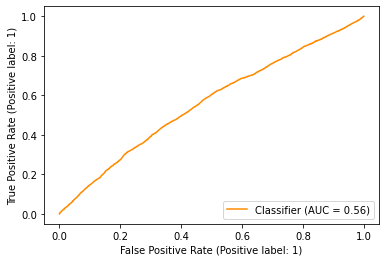

In [39]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    Y_test,
    Y_score,
    color="darkorange",
)